In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install windpowerlib
from windpowerlib import WindTurbine, ModelChain
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Liberation Serif']
plt.rcParams['font.sans-serif'] = ['Liberation Sans']
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import pandas as pd
import os

In [ ]:
COLORS = {
    'NCC-LR': '#009E73',
    'MPI-LR': '#0072B2',
    'IPSL': '#E69F00',
    'MOHC-LR': '#CC79A7',
    'JAP': '#56B4E9',
    'NCC-HR': '#009E73',
    'CMCC': '#F0E442',
    'MPI-HR': '#0072B2',
    'EC-EARTH': '#D55E00',
    'MOHC-HR': '#CC79A7',
    'ERA5': 'black',
    'MPI-LR-CMIP5': '#56B4E9',
    'MPI-LR-CMIP6': '#0072B2',
}

COLORS = {
    'NCC-LR': '#117733',
    'NCC-HR': '#117733',
    'MPI-LR': '#882255',
    'MPI-HR': '#882255',
    'MOHC-LR': '#332288',
    'MOHC-HR': '#332288',
    'IPSL': '#88CCEE',
    'JAP': '#CC6677',
    'CMCC': '#999933',
    'EC-EARTH': '#44AA99',
    'ERA5': 'black',
    'MPI-LR-CMIP5': '#CC6677',
    'MPI-LR-CMIP6': '#882255',
    'MPI-SMHI': '#332288',
    'MPI-Boundary': '#44AA99',
    'SMHI-Regional': '#88CCEE'
}

In [ ]:
FIG_WIDTH = 20
FIG_HEIGHT = 6
LABEL_SIZE = 30
REGIONAL_MODEL_NAME = 'Regional'
CONSTANT_GLOBAL_BOUNDARY_MODEL = 'MPI'
CONSTANT_REGIONAL_MODEL = 'SMHI'

In [ ]:
class FileInformation:
    def __init__(self, file_name, off_set):
        self.file_name = file_name
        loaded_data = np.load(file_name, allow_pickle=True)
        self.time = loaded_data['time']
        self.wp = np.concatenate(loaded_data['wp'])
        components = file_name.split('/')[-1].split('.')[0].split('_')
        model_category = components.pop(1)
        self.model_category = model_category
        model_name = components.pop(1)
        self.model_name = model_name
        if model_category == REGIONAL_MODEL_NAME:
            global_boundary_model = model_name.rsplit('-', 1)[0]
            regional_model = model_name.rsplit('-', 1)[-1]
            if global_boundary_model == CONSTANT_GLOBAL_BOUNDARY_MODEL and regional_model == CONSTANT_REGIONAL_MODEL:
                self.color = COLORS['MPI-SMHI']
            elif global_boundary_model == CONSTANT_GLOBAL_BOUNDARY_MODEL:
                self.color = COLORS['MPI-Boundary']
            elif regional_model == CONSTANT_REGIONAL_MODEL:
                self.color = COLORS['SMHI-Regional']
        else:
            self.color = COLORS[model_name]
        line_style = 'solid'
        if 'LR' in model_name and not 'CMIP' in model_name:
            line_style = (off_set, (10, 3))
        self.model_label = model_name
        self.arguments = {'color': self.color, 'linestyle': line_style}
        if 'ERA5' in model_name:
          self.arguments['linewidth'] = 5
        else:
          self.arguments['linewidth'] = 4
          self.arguments['alpha'] = 0.7

In [ ]:
def get_cumsum_difference(time, wind_power_values, years, height):
    for i in [0, 3]:
        root = f'/content/drive/MyDrive/Paper Spatial Resolution/wind_power/{years}/{height}'
        file_name =  f'sfcWind_Reanalysis_ERA5_hintcast_Europe-Land_{years}_start{i}am_{height}_wind_power.npz'
        era5_file_path = os.path.join(root, file_name)
        era5_file = FileInformation(era5_file_path, 0)
        era5_wind_power, era5_time = era5_file.wp, era5_file.time
        era5_wind_power = era5_wind_power.flatten()
        time_overlap = np.intersect1d(time, era5_time)
        if time_overlap.size:
            mask = np.isin(time, time_overlap)
            era5_mask = np.isin(era5_time, time_overlap)
            wind_power_values = (np.cumsum(wind_power_values[mask])
                                  / np.cumsum(era5_wind_power[era5_mask]))
            return time_overlap, wind_power_values

def calculate_bias(val, era5_val):
    return val / era5_val * 100 - 100

In [ ]:
def make_cumulative_wind_power_plot(ax, years, height, letter, list_of_models, left_plot=False):
    #ax.set_xlabel('Time', fontsize=TIME_SERIES_PLOT_LABEL_SIZE)
    ax.set_ylim(0.5,2.5)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    start, end = years.split('-')
    dates = np.arange(str(int(start)+1), end, dtype='datetime64[Y]')
    ax.set_xticks(dates[::2])
    ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE - 4)
    ax.tick_params(axis='both', which='minor', labelsize=LABEL_SIZE -8)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    root = f'/content/drive/MyDrive/Paper Spatial Resolution/wind_power/{years}/{height}'
    era5_file_path = os.path.join(root, f'sfcWind_Reanalysis_ERA5_hintcast_Europe-Land_{years}_start0am_{height}_wind_power.npz')
    era5_file = FileInformation(era5_file_path, 0)
    era5_wind_power, era5_time = era5_file.wp, era5_file.time
    era5_total_wind_power = np.sum(era5_wind_power)
    #ax.plot(era5_time[4*365:], np.ones(era5_time.shape)[4*365:], color='black', label='ERA5')

    if left_plot:
      ax.set_ylabel('relative power', fontsize=LABEL_SIZE)
    else:
      ax.yaxis.set_ticklabels([])

    ratios = []
    relative_biases = {}
    rel_bias = 0

    for model_information in list_of_models:
        wind_power_values, time = model_information.wp, model_information.time
        total_wind_power = np.sum(wind_power_values)
        ratios.append(total_wind_power/era5_total_wind_power)
        rel_bias = calculate_bias(total_wind_power, era5_total_wind_power)
        relative_biases[model_information.model_label] = rel_bias

        time, wind_power_values = get_cumsum_difference(time, wind_power_values, years, height)

        label = model_information.model_label
        if not 'LR' in label:
          ax.plot(time[4*365:], wind_power_values[4*365:], label=label.replace('-HR', ''),
                  **model_information.arguments)
        else:
          ax.plot(time[4*365:], wind_power_values[4*365:],
                  **model_information.arguments)

    ax.plot(time[4*365:], np.ones(time.shape)[4*365:], color='black', label='ERA5', linewidth=4)

    #ax.legend(frameon=False, fontsize=LABEL_SIZE-2, loc='lower center',
    #                  bbox_to_anchor=(0.5, 1.15), ncol=3)

    ax.text(
        x=0.03,
        y=0.97,
        s=letter,
        transform=ax.transAxes,
        fontsize=LABEL_SIZE+6,
        fontweight='bold',
        va='top',
        ha='left'
    )

    ax.set_ylim(0.5,2.3)

    return ax

In [ ]:
def create_model_file_list(years, height):
  list_of_models = []
  root = f'/content/drive/MyDrive/Paper Spatial Resolution/wind_power/{years}/{height}'
  off_set = int(0)
  for root, dirs, files in os.walk(root):
      for filename in files:
          file_path = os.path.join(root, filename)
          my_file = FileInformation(file_path, off_set)
          if not 'ERA5' in my_file.model_name:
            list_of_models.append(my_file)
          if 'LR' in my_file.model_label:
            off_set += 5
  return list_of_models

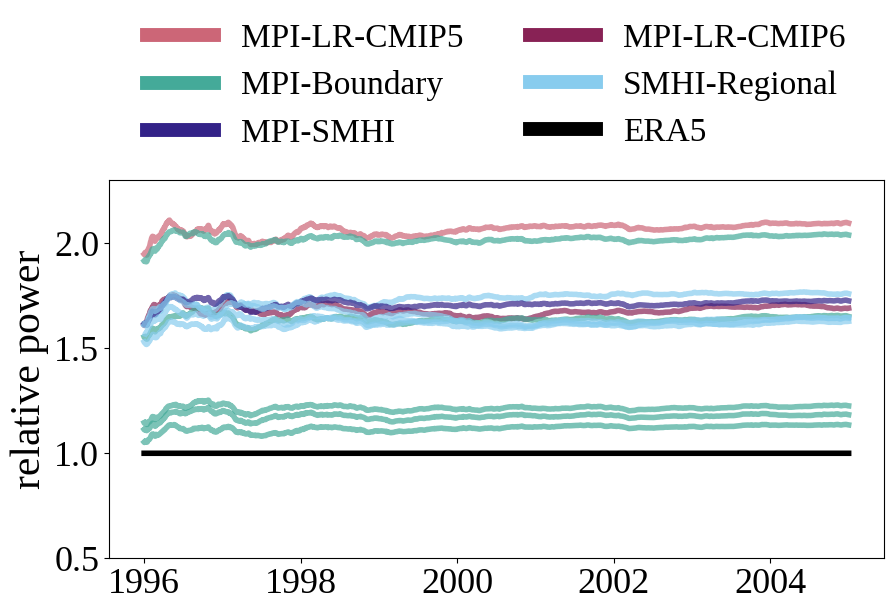

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(FIG_WIDTH/2, FIG_HEIGHT+FIG_HEIGHT/8), height_ratios=[1, 4])
ax = axes[1]
years = '1995-2005'
height = '126m'
list_of_models = create_model_file_list(years, height)
ax = make_cumulative_wind_power_plot(ax, years, height, '', list_of_models, True)
ax_legend = axes[0]
ax_legend.axis('off')
LABELS = {
    'MPI-LR-CMIP5': Line2D([], [], color=COLORS['MPI-LR-CMIP5']),
    'MPI-Boundary':  Line2D([], [], color=COLORS['MPI-Boundary']),
    'MPI-SMHI':  Line2D([], [], color=COLORS['MPI-SMHI']),
    'MPI-LR-CMIP6':  Line2D([], [], color=COLORS['MPI-LR-CMIP6']),
    'SMHI-Regional':  Line2D([], [], color=COLORS['SMHI-Regional']),
    'ERA5': Line2D([], [], color=COLORS['ERA5']),
}

legend = ax_legend.legend(handles=LABELS.values(), labels=LABELS.keys(), frameon=False,
                 fontsize=24, loc='center', ncol=2)
for line in legend.get_lines():
    line.set_linewidth(10)
legend_name = f'cumulative_wp_1995-2005'
fig.savefig(f'{legend_name}.pdf', bbox_inches="tight")

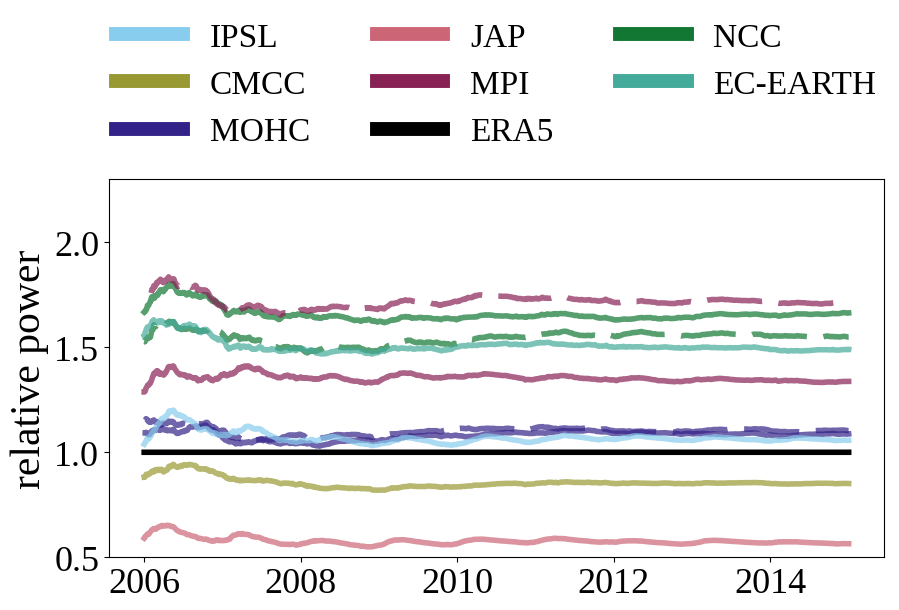

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(FIG_WIDTH/2, FIG_HEIGHT+FIG_HEIGHT/8), height_ratios=[1, 4])
ax = axes[1]
years = '2005-2015'
height = '126m'
list_of_models = create_model_file_list(years, height)
ax = make_cumulative_wind_power_plot(ax, years, height, '', list_of_models, True)
ax_legend = axes[0]
ax_legend.axis('off')

LABELS = {
    'IPSL': Line2D([], [], color=COLORS['IPSL']),
    'CMCC':  Line2D([], [], color=COLORS['CMCC']),
    'MOHC':  Line2D([], [], color=COLORS['MOHC-HR']),
    'JAP':  Line2D([], [], color=COLORS['JAP']),
    'MPI':  Line2D([], [], color=COLORS['MPI-HR']),
    'ERA5': Line2D([], [], color=COLORS['ERA5']),
    'NCC':  Line2D([], [], color=COLORS['NCC-HR']),
    'EC-EARTH':  Line2D([], [], color=COLORS['EC-EARTH'])
}

legend = ax_legend.legend(handles=LABELS.values(), labels=LABELS.keys(), frameon=False,
                 fontsize=24, loc='center', ncol=3)
for line in legend.get_lines():
    line.set_linewidth(10)

legend_name = f'cumulative_wp_2005-2015'
fig.savefig(f'{legend_name}.pdf', bbox_inches="tight")

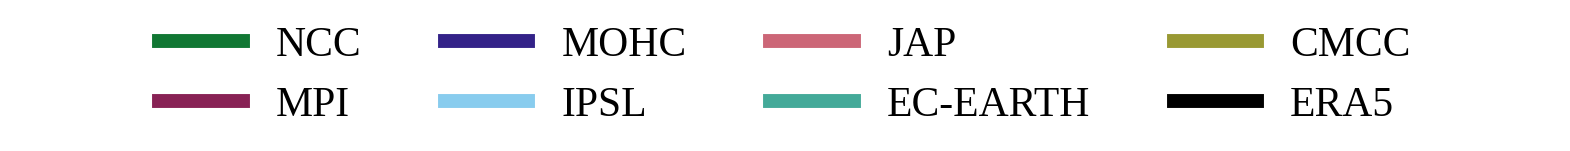

In [ ]:
fig_legend, ax_legend = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT / 4))
ax_legend.axis('off')

LABELS = {
    'NCC':  Line2D([], [], color=COLORS['NCC-LR'], label='NCC'),
    'MPI':  Line2D([], [], color=COLORS['MPI-LR'],  label='MPI'),
    'MOHC':  Line2D([], [], color=COLORS['MOHC-LR'], label='MOHC'),
    'IPSL': Line2D([], [], color=COLORS['IPSL'], label='IPSL'),
    'JAP':  Line2D([], [], color=COLORS['JAP'], label='JAP'),
    'EC-EARTH':  Line2D([], [], color=COLORS['EC-EARTH'], label='EC-EARTH'),
    'CMCC':  Line2D([], [], color=COLORS['CMCC'], label='CMCC'),
    'ERA5': Line2D([], [], color=COLORS['ERA5'], label='ERA5'),
}

legend = ax_legend.legend(handles=LABELS.values(), labels=LABELS.keys(), frameon=False,
                 fontsize=30, loc='center', ncol=4)
for line in legend.get_lines():
    line.set_linewidth(10)

legend_name = f'legend_europeland_126m_2005-2015'
fig_legend.savefig(f'{legend_name}.pdf', bbox_inches="tight")

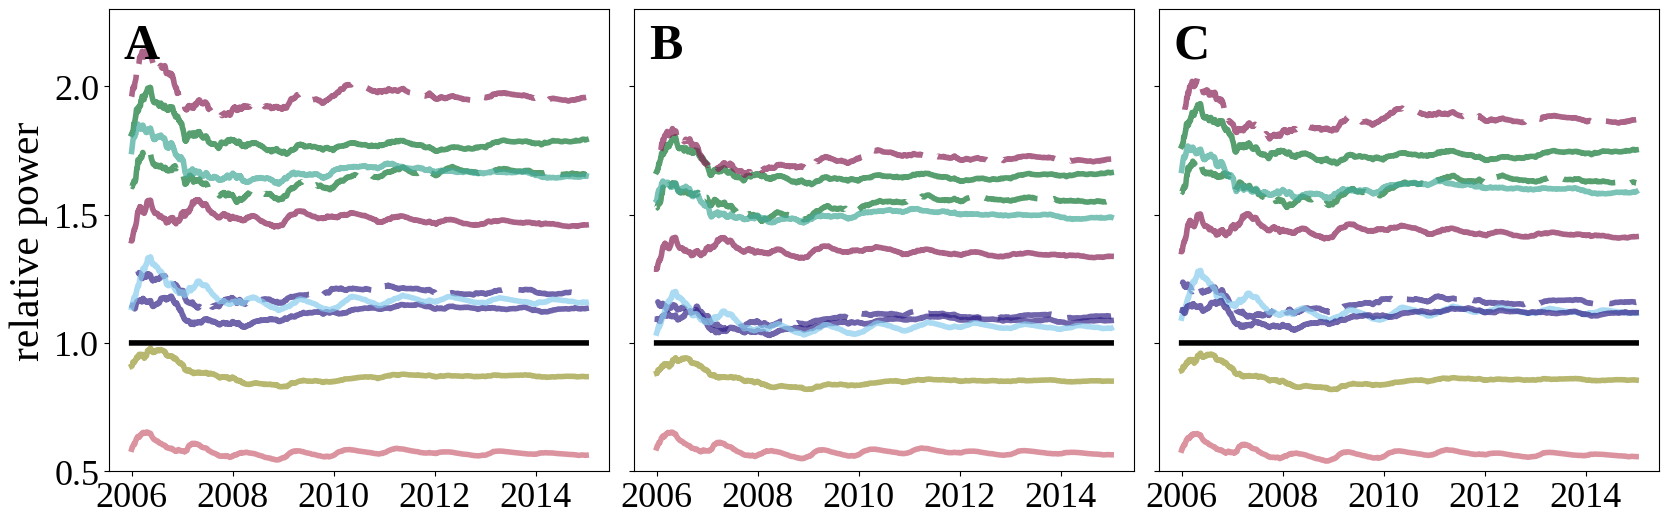

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(FIG_WIDTH, FIG_HEIGHT))
plt.subplots_adjust(wspace=0.05)
ax = axes[0]
years = '2005-2015'
height = '85m'
list_of_models = create_model_file_list(years, height)
ax = make_cumulative_wind_power_plot(ax, years, height, 'A', list_of_models, True)
ax = axes[1]
years = '2005-2015'
height = '126m'
list_of_models = create_model_file_list(years, height)
ax = make_cumulative_wind_power_plot(ax, years, height, 'B', list_of_models)
ax = axes[2]
years = '2005-2015'
height = '140m'
list_of_models = create_model_file_list(years, height)
ax = make_cumulative_wind_power_plot(ax, years, height, 'C', list_of_models)

fig.savefig(f'cumulative_wp_plot_turbine_comparison.pdf', bbox_inches="tight")